In [16]:
%%markdown

# Online Model Swapping in SVE-Cachesim


## Project Structure

### Source Files
This project consists of four files. 
* `sveCacheSim.py`: The simulation driver
* `CacheModels.py`: All of the cache models and model swapping methodology
* `PhaseDetector.py`: The phase detection methdology
* `Markov.py`: An implementation of a predictive markov chain
    
### Trace Files
Trace files that we used are in `traces/`. They are 
* `traces/memtrace.meabo.i125.N512.P521.L1.log`
* `traces/memtrace.meabo.i125.N512.P521.L2.log`
* `traces/memtrace.meabo.i125.N1536.P521.L3.log`

We will refer to these traces later as 'small', 'medium' and 'large', respectively. 
The naming of each file indicates how we ran Meabo to genrate that trace. So, `i125` means we ran with `-i 125`, 
`N512` means we use an input size of 512 for any phase we ran, `P512` means we ran with `-P 521` which means we 
ran phases 1, 4, and 10, and `Ln` means
we ran with `-L n`, with n indicating the number of times each phase is run. 

### Gold Files
The files in `gold/` represent the proper stats when running the cache without any model swapping. There is one for each trace file. The mapping 
from trace file to gold file in in sveCacheSim.simulation so you never forget! In fact, you don't actually have to worry about the trace files and 
the gold files at all, as that is all handled for you by that function. Simply tell it the trace_id of 'small', 'medium' or 'large', and 
it takes care of the rest! 

### Base Models
These files allow you to configure the base cache. We will only use `base-models/3-level.json` in this work. 

## Running Some Simulations
The first two files need to be imported before we can run our simulations. 


# Online Model Swapping in SVE-Cachesim


## Project Structure

### Source Files
This project consists of four files. 
* `sveCacheSim.py`: The simulation driver
* `CacheModels.py`: All of the cache models and model swapping methodology
* `PhaseDetector.py`: The phase detection methdology
* `Markov.py`: An implementation of a predictive markov chain
    
### Trace Files
Trace files that we used are in `traces/`. They are 
* `traces/memtrace.meabo.i125.N512.P521.L1.log`
* `traces/memtrace.meabo.i125.N512.P521.L2.log`
* `traces/memtrace.meabo.i125.N1536.P521.L3.log`

We will refer to these traces later as 'small', 'medium' and 'large', respectively. 
The naming of each file indicates how we ran Meabo to genrate that trace. So, `i125` means we ran with `-i 125`, 
`N512` means we use an input size of 512 for any phase we ran, `P512` means we ran with `-P 521` which means we 
ran phases 1, 4, and 10, and `Ln` means
we ran with `-L n`, with n indicating the number of times each phase is run. 

### Gold Files
The files in `gold/` represent the proper stats when running the cache without any model swapping. There is one for each trace file. The mapping 
from trace file to gold file in in sveCacheSim.simulation so you never forget! In fact, you don't actually have to worry about the trace files and 
the gold files at all, as that is all handled for you by that function. Simply tell it the trace_id of 'small', 'medium' or 'large', and 
it takes care of the rest! 

### Base Models
These files allow you to configure the base cache. We will only use `base-models/3-level.json` in this work. 

## Running Some Simulations
The first two files need to be imported before we can run our simulations. 


In [110]:
import sveCacheSim as sim
import CacheModels
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from tqdm import tqdm
import importlib
importlib.reload(sim)
pass

In [54]:
%%markdown

## Meabo Traces

Before we run any simulations, we should take a look at what our phase detector is doing with the traces we give it. 
We'll run some simulations now, but we won't worry about the stats. We'll just grab the phase trace that gets included with the stats. 
As we are passing `None` as the first argument, these simulations will not do any model swapping. (Of course, model swapping does not affect the phase trace anyways.)

### Meabo Changes

For those of you familiar with Meabo, you'll notice a few changes. The first, mentioned above, is that we added a `-L` argument to allow users
to run each phase multiple times. The second is that we added a marker phase between the Meabo phases so we can be totally sure that we 
know that our phase detection is working. This phase is designed to write over a small location a few times, so it should be essentially 100% write hits. 



## Meabo Traces

Before we run any simulations, we should take a look at what our phase detector is doing with the traces we give it. 
We'll run some simulations now, but we won't worry about the stats. We'll just grab the phase trace that gets included with the stats. 
As we are passing `None` as the first argument, these simulations will not do any model swapping. (Of course, model swapping does not affect the phase trace anyways.)

### Meabo Changes

For those of you familiar with Meabo, you'll notice a few changes. The first, mentioned above, is that we added a `-L` argument to allow users
to run each phase multiple times. The second is that we added a marker phase between the Meabo phases so we can be totally sure that we 
know that our phase detection is working. This phase is designed to write over a small location a few times, so it should be essentially 100% write hits. 


In [25]:
stats_small, _  = sim.simulation(None, trace_id='small',  show_summary=False)
stats_medium, _ = sim.simulation(None, trace_id='medium', show_summary=False)
stats_large, _  = sim.simulation(None, trace_id='large',  show_summary=False)

[xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx] [Elapsed: 2:17]          
[xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx] [Elapsed: 3:58]          
[xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx] [Elapsed: 14:46]          


In [27]:
%%markdown

### Phase Trace Object
We first need to grab the phase trace object from the stats of our simulation. It is stored in `stats_*.phase_trace`. This object
has type `PhaseTrace` which is defined in `PhaseDetector.py` and includes 4 fields.

* `trace`: The phase assigned to each interval. -1 represents an interval not identified as part of a phase. 
* `nphases`: The number of unique phases identified.
* `phase_count`: A list of length nphases where phase_count[i] is the number of intervals assigned to phase i
* `phase_unique`: A list of length nphases where phase_unique[i] is the number of times phase i was entered

Let's take a look at these for the 'large' trace. 


### Phase Trace Object
We first need to grab the phase trace object from the stats of our simulation. It is stored in `stats_*.phase_trace`. This object
has type `PhaseTrace` which is defined in `PhaseDetector.py` and includes 4 fields.

* `trace`: The phase assigned to each interval. -1 represents an interval not identified as part of a phase. 
* `nphases`: The number of unique phases identified.
* `phase_count`: A list of length nphases where phase_count[i] is the number of intervals assigned to phase i
* `phase_unique`: A list of length nphases where phase_unique[i] is the number of times phase i was entered

Let's take a look at these for the 'large' trace. 


In [37]:
trace = stats_large.phase_trace
print('Identified', trace.nphases, 'phases')
print('Number of intervals assigned to each phase', trace.phase_count)
print('Number of times each phase was entered', trace.phase_unique)

Identified 5 phases
Number of intervals assigned to each phase [67, 113, 232, 112, 338]
Number of times each phase was entered [1, 10, 3, 3, 3]


In [40]:
%%markdown

This looks good, as we expect each of our three Meabo phases to be entered 3 times which is what we see in the `phase_unique` data. 

### Phase Plot

We should take a look at the trace itself. Let's plot the phase traces for each of the traces.


This looks good, as we expect each of our three Meabo phases to be entered 3 times which is what we see in the `phase_unique` data. 

### Phase Plot

We should take a look at the trace itself. Let's plot the phase traces for each of the traces.


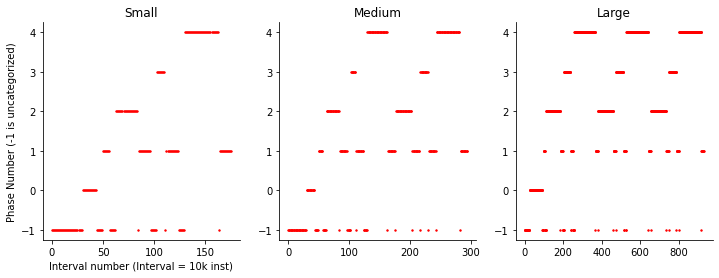

In [119]:
trace_small  = stats_small.phase_trace.trace
trace_medium = stats_medium.phase_trace.trace
trace_large  = stats_large.phase_trace.trace

def plot_trace(ax, label, trace, axis_labels):
    ax.scatter([*range(len(trace))], trace,s=2, color='red')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title(label)
    if axis_labels:
        ax.set_ylabel('Phase Number (-1 is uncategorized)')
        ax.set_xlabel('Interval number (Interval = 10k inst)')

fig, ax = plt.subplots(1, 3, figsize=(12,4))
plot_trace(ax[0], 'Small',  trace_small,  True)
plot_trace(ax[1], 'Medium', trace_medium, False)
plot_trace(ax[2], 'Large',  trace_large,  False)
#plt.savefig('plots/phase-traces.svg')
plt.show()

In [57]:
%%markdown

We see above that our marker phase is identified as phase 1 each time and the Meabo phases (2, 3, 4) are run the expected number of times
int each trace. It is hard to tell from the scale here, but the Meabo phases in the Large trace run longer than in the other two.  

## Collecting Data

It's time to actually look at the results of our simulation. We'll be looking at four different cache models, 
* `FixedHitRate`
* `Markov4`
* `Markov8`
* `All`

The first three will train the same type of model for each phase. The last model will train all of the previous three for each phase, 
then pick between them. 

We have already run the base model, so well stick that in our dictionary, and run the rest. Let's view the summary for these models as they run.


We see above that our marker phase is identified as phase 1 each time and the Meabo phases (2, 3, 4) are run the expected number of times
int each trace. It is hard to tell from the scale here, but the Meabo phases in the Large trace run longer than in the other two.  

## Accuracy Study

It's time to actually look at the results of our simulation. We'll be looking at four different cache models, 
* `FixedHitRate`
* `Markov4`
* `Markov8`
* `All`

The first three will train the same type of model for each phase. The last model will train all of the previous three for each phase, 
then pick between them. 

We have already run the base model, so well stick that in our dictionary, and run the rest. Let's view the summary for these models as they run.


In [73]:
stats = {}
stats['base']    = stats_small

stats['fr'], _   = sim.simulation(CacheModels.FixedHitRateSmartCache, trace_id='small')
stats['m4'], _   = sim.simulation(CacheModels.Markov4StateSmartCache, trace_id='small')
stats['m8'], _   = sim.simulation(CacheModels.Markov8StateSmartCache, trace_id='small')
stats['all'], _  = sim.simulation(CacheModels.AllModelSmartCache,     trace_id='small')

[xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx] [Elapsed: 2:42]          
Trace: memtrace.meabo.i125.N512.P521.L1.log
Summary:
 L1 percent change in hit count: 0.01%
 L2 percent change in hit count: 19.71%
 L3 percent change in hit count: -7.04%
 Percent change in cycles: -19.49%
[xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx] [Elapsed: 2:50]          
Trace: memtrace.meabo.i125.N512.P521.L1.log
Summary:
 L1 percent change in hit count: -0.52%
 L2 percent change in hit count: 23.26%
 L3 percent change in hit count: -4.31%
 Percent change in cycles: -17.24%
[xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx] [Elapsed: 2:54]          
Trace: memtrace.meabo.i125.N512.P521.L1.log
Summary:
 L1 percent change in hit count: -0.78%
 L2 percent change in hit count: 15.14%
 L3 percent change in hit count: -7.36%
 Percent change in cycles: -3.53%
[xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx] [Elapsed: 2:42]          
Trace: memtrace.meabo.i125.N512.P521.L1.log
Summary:
 L1 percent change in hit count: -0.06%
 L2 perce

In [74]:
%%markdown 

## Accuracy 

Ok, first thing we should check out is how well the models did at predicting the proper hits or misses. First we'll collect this data into
a dataframe called accuracy_df, then we'll plot it. 


## Accuracy 

Ok, first thing we should check out is how well the models did at predicting the proper hits or misses. First we'll collect this data into
a dataframe called accuracy_df, then we'll plot it. 


In [107]:
def get_acc(st1, st2, phase):
    # t1 is assumed to be from the base cache
    
    t1 = st1.cache_trace[0] # cache trace from st1
    t2 = st2.cache_trace[0] # cache trace from st2
    
    # Just get accesses where were are in phase `phase` and in state is Swapped (2)
    pick_state = t2['state'] == 2
    pick_phase = t2['phase'] == phase
    
    pick = np.logical_and(pick_state, pick_phase)
    
    # Get the hit/miss from each 
    t1_hits = t1['isHit'][pick]
    t2_hits = t2['isHit'][pick]
    
    num_correct = np.sum(np.equal(t1_hits, t2_hits))
    acc = num_correct / len(t1_hits)
    
    return acc
    
nphases = stats['base'].phase_trace.nphases
name_map={'fr':'Fixed Rate', 'm4': 'Markov 4', 'm8':'Markov 8', 'all':'All'}
data = {}
for name in stats:
    if name is 'base' or name is 'all':
        continue
    acc = []
    for i in range(nphases):
        acc.append(get_acc(stats['base'], stats[name], i))
    data[name_map[name]] = acc
accuracy_df = pd.DataFrame(data)
print(accuracy_df)

   Fixed Rate  Markov 4  Markov 8
0    0.688158  0.709025  0.763008
1    0.988111  0.974292  0.972607
2    0.698668  0.713695  0.869632
3    0.539333  0.625350  0.672950
4    0.818771  0.852806  0.888687


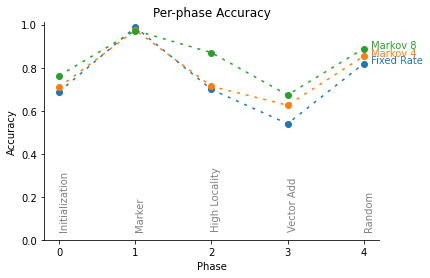

In [118]:
ny = 5
ax=plt.gca()
accuracy_df.plot(xticks=[*range(0,5)],
        yticks=[i/ny for i in range(0,ny+1)], 
             title='Per-phase Accuracy',ax=ax, 
             marker='o', linestyle=(0, (2,4)))
ax.set_ylabel('Accuracy')
ax.set_xlabel('Phase')
ax.get_legend().remove()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
cmap = plt.get_cmap("tab10")
ax.text( x=4.1, y=accuracy_df['Fixed Rate'][ny-1], s='Fixed Rate', color=cmap(0))
ax.text( x=4.1, y=accuracy_df['Markov 4'][ny-1], s='Markov 4', color=cmap(1))
ax.text( x=4.1, y=accuracy_df['Markov 8'][ny-1], s='Markov 8', color=cmap(2))

ax.text(x=0, y=.05, s='Initialization', rotation=90, color='grey')
ax.text(x=1, y=.05, s='Marker', rotation=90, color='grey')
ax.text(x=2, y=.05, s='High Locality', rotation=90, color='grey')
ax.text(x=3, y=.05, s='Vector Add', rotation=90, color='grey')
ax.text(x=4, y=.05, s='Random', rotation=90, color='grey')

#plt.savefig('plots/per-phase-accuracy.svg')

In [94]:
%%markdown

## Accuracy Over Time
Let's now take a look at how accuracy changes over the course of a simulation. Does it get worse over time? 

As we're using the small trace, we won't see much here. Please re-run the notebook to get a better large chart. 

The reason a legend isn't generated is because it is hard to place it well. To get a legend, re-run the plot and uncomment the line labeled as such. 
Then grab the legend and paste it onto the plot in a good area. 


## Accuracy Over Time
Let's now take a look at how accuracy changes over the course of a simulation. Does it get worse over time? 

As we're using the small trace, we won't see much here. Please re-run the notebook to get a better large chart. 

The reason a legend isn't generated is because it is hard to place it well. To get a legend, re-run the plot and uncomment the line labeled as such. 
Then grab the legend and paste it onto the plot in a good area. 


In [92]:
interval_len = 10000
def acc_over_time(st1, st2, phase):
    
    t1 = st1.cache_trace[0] # cache trace from st1
    t2 = st2.cache_trace[0] # cache trace from st2
    
    # Just get accesses where were are in phase `phase` and in state is Swapped (2)
    pick_state = t2['state'] == 2
    pick_phase = t2['phase'] == phase
    
    pick = np.logical_and(pick_state, pick_phase)
    
    # Get the hit/miss from each 
    t1_hits = t1['isHit'][pick]
    t2_hits = t2['isHit'][pick]
    
    nintervals = int(len(t1_hits) // interval_len)-1
    
    acc = []
    
    for i in range(nintervals):
        start = i*interval_len
        end   = (i+1)*interval_len
        t1_hits_rest = t1_hits[start:end]
        t2_hits_rest = t2_hits[start:end]
    
        num_correct = np.sum(np.equal(t1_hits_rest, t2_hits_rest))
        acc.append(num_correct / interval_len)
    
    return acc

nphases = stats['base'].phase_trace.nphases
name_map={'fr':'Fixed Rate', 'm4': 'Markov 4', 'm8':'Markov 8', 'all':'All'}
all_df = {}
for i in range(nphases):
    data = {}
    for name in stats:
        if name is 'base':
            continue
        data[name_map[name]] = acc_over_time(stats['base'], stats[name], i)
    data_df = pd.DataFrame(data)    
    all_df[i] = data_df


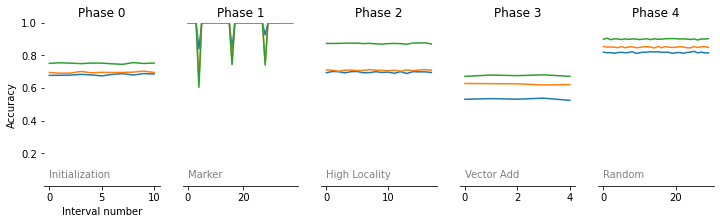

In [120]:
pretty=['Initialization', 'Marker', 'High Locality', 'Vector Add', 'Random']
def acc_over_time_plot(ax, approx, m4, m8, phase):
    ax.plot(approx, label='Fixed Rate')
    ax.plot(m4, label='Markov 4')
    ax.plot(m8, label='Markov 8')    
    ax.set_ylim((0,1))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.get_yaxis().set_ticks([])
    ax.set_title('Phase {}'.format(phase))
    ax.text(x=0, y=.05, s=pretty[phase], color='grey')
    if phase == 0:
        ax.set_ylabel('Accuracy')
        ax.get_yaxis().set_ticks([.2, .4, .6, .8, 1.])
        ax.set_xlabel('Interval number')
    if phase == 4:
        pass
        #ax.legend(loc=10) ##UNCOMMENT ME FOR LEGEND

fig, ax = plt.subplots(1, 5, figsize=(12,3), squeeze=False)
for phase in range(5):    
    acc_over_time_plot(ax[0,phase], 
          all_df[phase]['Fixed Rate'],
          all_df[phase]['Markov 4'],
          all_df[phase]['Markov 8'],
          phase)
#plt.savefig('plots/acc-over-time.svg')
plt.show()


In [95]:
%%markdown

## Accuracy as a function of Model Size

This is just a fun little plot. 


## Accuracy as a function of Model Size

This is just a fun little plot. 


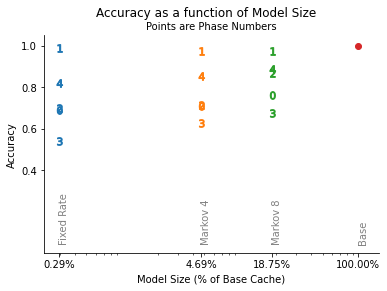

In [121]:
bs=8192
sz = {'base':1, 'fr':24/bs, 'm4':(3 * (4 * 4) * 8)/bs, 'm8':(3 * (8 * 8) * 8)/bs}

fig, ax = plt.subplots()
cmap = plt.get_cmap("tab10")
for i in range(5):
    ax.scatter([sz['fr']], accuracy_df['Fixed Rate'][i], marker='${}$'.format(i), color=cmap(0), s=60)
for i in range(5):
    ax.scatter([sz['m4']], accuracy_df['Markov 4'][i], marker='${}$'.format(i), color=cmap(1), s=60)
for i in range(5):
    ax.scatter([sz['m8']], accuracy_df['Markov 8'][i], marker='${}$'.format(i), color=cmap(2), s=60)
ax.scatter(1,1,  color=cmap(3))
ax.set_xscale('log')


labs=np.float64([24/bs, (3 * (4 * 4) * 8)/bs, (3 * (8 * 8) * 8)/bs, 1])*100
ax.get_xaxis().set_ticks([24/bs, (3 * (4 * 4) * 8)/bs, (3 * (8 * 8) * 8)/bs, 1])
ax.set_xticklabels(['{:.2f}%'.format(labs[i]) for i in range(4)])

ax.get_yaxis().set_ticks([.4,.6, .8, 1])

ax.set_xlabel('Model Size (% of Base Cache)')
ax.set_ylabel('Accuracy')
ax.set_ylim(0,1.05)
ax.set_xlim(0,1.5)
ax.text(x=labs[0]/100, y=.05, s='Fixed Rate', rotation=90, color='grey')
ax.text(x=labs[1]/100, y=.05, s='Markov 4', rotation=90, color='grey')
ax.text(x=labs[2]/100, y=.05, s='Markov 8', rotation=90, color='grey')
ax.text(x=labs[3]/100, y=.05, s='Base', rotation=90, color='grey')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_title('Points are Phase Numbers', size=10)
fig.suptitle('Accuracy as a function of Model Size')

#plt.savefig('plots/acc_vs_modelsize.svg')

plt.show()

In [101]:
%%markdown

## Locality Analysis

Finally, we get to the hardest plot to generate, the locality plot. 


## Locality Analysis

Finally, we get to the hardest plot to generate, the locality plot. 


In [111]:
def index(array, item):
    for idx, val in enumerate(array):
        if val == item:
            return idx
    return -1

def rightshift(val: np.uint64, shift: np.uint64) -> np.uint64:
    return val >> shift

def reuse(trace, shift, outfile=None):
    stack = np.array([], dtype=np.int64)
    out = []
    for i in tqdm(range(len(trace))):
        addr = rightshift(trace[i], np.uint64(shift)) # Cache line
        idx = index(stack, addr)
        if idx == -1:
            stack = np.insert(stack, 0, addr)
        else:
            out.append(idx)
            stack = np.delete(stack, idx)
            stack = np.insert(stack, 0, addr)

    if outfile is not None:
        save_object(out, outfile)
        print('Wrote reuse trace to: {}'.format(outfile))
        
    return out


In [113]:
reuse_perphase_base    = {}
reuse_perphase_approx  = {}
reuse_perphase_markov4 = {}
reuse_perphase_markov8 = {}
gran=6

def get_addrs(data, phase):
    df = pd.DataFrame(data)
    return np.array(df[df['phase']==phase]['addr'], dtype=np.uint64)

for phase in range(0,5):
    reuse_perphase_base[phase] = reuse(get_addrs(stats['base'].cache_trace[1], phase), gran)
    reuse_perphase_approx[phase] = reuse(get_addrs(stats['fr'].cache_trace[1], phase), gran)
    reuse_perphase_markov4[phase] = reuse(get_addrs(stats['m4'].cache_trace[1], phase), gran)
    reuse_perphase_markov8[phase] = reuse(get_addrs(stats['m8'].cache_trace[1], phase), gran)

100%|██████████| 4826/4826 [00:02<00:00, 2337.25it/s]
0it [00:00, ?it/s]
100%|██████████| 36357/36357 [00:02<00:00, 17691.74it/s]


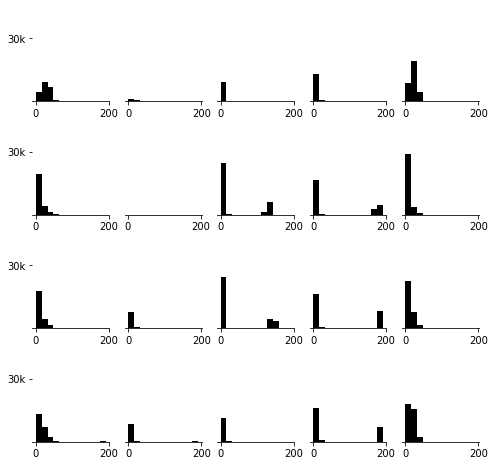

In [123]:
binwidth=16
#maxbin={1:50, 2:850, 3:225, 4:50}
maxbin={0:200,1:200, 2:200, 3:200, 4:200}

yl=45000
ylim={0:yl,1:yl, 2:yl, 3:yl, 4:yl}


def bins(data, binwidth, maxbin):
    #return range(min(data), min(maxbin, max(data) + binwidth), binwidth)
   # print(data)
    return range(min(data), maxbin, binwidth)

def plot(ax, data, title, phase):
    if not data:
        data = [1]
    ax.hist(data, bins=bins(data, binwidth, maxbin=maxbin[phase]), color='black')
    ax.set_ylim((0,ylim[phase]))
    #ax.suptitle(title)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.get_yaxis().set_ticks([])
    if phase == 0:
        ax.get_yaxis().set_ticks([30000])
        ax.set_yticklabels(['30k'])
    
#plot(reuse_perphase_base[1], 'Base Cache', maxbin=maxbin[1])
#plot(reuse_perphase_approx[1], 'Fixed Rate Cache', maxbin=maxbin[1])
#plot(reuse_perphase_markov4[1], '4-State Markov Cache', maxbin=maxbin[1])
#plot(reuse_perphase_markov8[1], '8-State Markov Cache', maxbin=maxbin[1])

#i = 1

fig, ax = plt.subplots(4, 5, figsize=(8,8))
for i in range(5):
    #phase = i+1
    phase=i
    
    plot(ax[0,i], reuse_perphase_base[phase], 'Base Cache', phase)
    plot(ax[1,i], reuse_perphase_approx[phase], 'Fixed Rate Cache', phase)
    plot(ax[2,i], reuse_perphase_markov4[phase], '4-State Markov Cache', phase)
    plot(ax[3,i], reuse_perphase_markov8[phase], '8-State Markov Cache', phase)

#plt.savefig('plots/locality_per_phase.svg')
plt.show()